
[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
Contents of dataset directory:
['list_landmarks_align_celeba.csv', 'list_bbox_celeba.csv', 'list_attr_celeba.csv', 'list_eval_partition.csv', 'img_align_celeba']

Dataset initialized with:
Root directory: ./celeba-dataset
CSV file: ./celeba-dataset/list_attr_celeba.csv
Image directory: ./celeba-dataset/img_align_celeba/img_align_celeba
Total samples: 202599

First sample loaded successfully!
Image shape: torch.Size([3, 64, 64])
Label: 0

Dataset splits:
Training samples: 141819
Validation samples: 30390
Test samples: 30390

Batch de

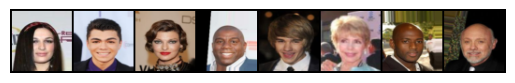

In [1]:
# First install required packages
!pip install opendatasets --quiet
!pip install kaggle --quiet
import opendatasets as od
import os
import pandas as pd
import torch
import torchvision 
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt

# Download dataset using Kaggle credentials
dataset_url = "https://www.kaggle.com/datasets/jessicali9530/celeba-dataset"
od.download(dataset_url)

# Verify download
data_dir = "./celeba-dataset"
print("Contents of dataset directory:")
print(os.listdir(data_dir))


class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        # Automatically find CSV file
        self.csv_path = self._find_csv()
        self.attributes = pd.read_csv(self.csv_path)
        
        # Automatically find image directory
        self.image_dir = self._find_image_dir()
        
        print(f"\nDataset initialized with:")
        print(f"Root directory: {root_dir}")
        print(f"CSV file: {self.csv_path}")
        print(f"Image directory: {self.image_dir}")
        print(f"Total samples: {len(self)}")

    def _find_csv(self):
        """Find CSV file in root or subdirectories"""
        for root, dirs, files in os.walk(self.root_dir):
            if "list_attr_celeba.csv" in files:
                return os.path.join(root, "list_attr_celeba.csv")
        raise FileNotFoundError("Could not find list_attr_celeba.csv")

    def _find_image_dir(self):
        """Find image directory recursively"""
        target_dir = "img_align_celeba"
        for root, dirs, files in os.walk(self.root_dir):
            if target_dir in dirs:
                path = os.path.join(root, target_dir)
                if len(os.listdir(path)) > 1000:  # Verify it's not empty
                    return path
        raise FileNotFoundError("Could not find image directory")

    def __len__(self):
        return len(self.attributes)

    def __getitem__(self, idx):
        img_name = self.attributes.iloc[idx, 0]
        img_path = os.path.join(self.image_dir, img_name)
        
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")
            
        image = Image.open(img_path).convert('RGB')
        label = 1 if self.attributes.iloc[idx, 39] == 1 else 0  # Young attribute at index 39

        if self.transform:
            image = self.transform(image)

        return image, label

# ---------------------------
# Initialize Dataset
# ---------------------------

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Initialize with automatic path detection
full_dataset = CelebADataset(data_dir, transform=transform)

# ---------------------------
# Verify Dataset
# ---------------------------

# Test loading
try:
    sample_img, sample_label = full_dataset[0]
    print("\nFirst sample loaded successfully!")
    print(f"Image shape: {sample_img.shape}")
    print(f"Label: {sample_label}")
except Exception as e:
    print(f"\nError loading sample: {str(e)}")

# ---------------------------
# Dataset Splitting
# ---------------------------

train_size = int(0.7 * len(full_dataset))
val_size = (len(full_dataset) - train_size) // 2
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

print(f"\nDataset splits:")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# ---------------------------
# Data Loaders & Visualization
# ---------------------------

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

def show_batch(dataloader):
    images, labels = next(iter(dataloader))
    print("\nBatch details:")
    print(f"Image tensor shape: {images.shape}")  # Should be [64, 3, 64, 64]
    print(f"Label tensor shape: {labels.shape}")  # Should be [64]
    
    # Unnormalize and display
    img_grid = torchvision.utils.make_grid(images[:8], normalize=True)
    plt.imshow(img_grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

show_batch(train_loader)

In [5]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        return self.main(input).view(-1)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lambda_gp = 10
n_critic = 5
num_epochs = 10

generator = Generator(100).to(device)
critic = Critic().to(device)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_C = torch.optim.Adam(critic.parameters(), lr=0.0002, betas=(0.5, 0.999))

def compute_gradient_penalty(critic, real, fake):
    alpha = torch.rand(real.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
    d_interpolates = critic(interpolates)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Training loop
for epoch in range(num_epochs):
    for i, (real, _) in enumerate(train_loader):
        real = real.to(device)
        current_batch = real.size(0)
        
        # Train Critic
        for _ in range(n_critic):
            z = torch.randn(current_batch, 100, 1, 1, device=device)
            fake = generator(z)
            
            real_validity = critic(real)
            fake_validity = critic(fake.detach())
            gradient_penalty = compute_gradient_penalty(critic, real, fake.detach())
            loss_C = -real_validity.mean() + fake_validity.mean() + lambda_gp * gradient_penalty
            
            optimizer_C.zero_grad()
            loss_C.backward()
            optimizer_C.step()

        
        # Train Generator
        fake = generator(z)
        loss_G = -critic(fake).mean()
        print("Epoch:", epoch, "Batch:", i, "Loss_G:", loss_G.item())
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

Epoch: 0 Batch: 0 Loss_G: 9.466499328613281
Epoch: 0 Batch: 1 Loss_G: 15.137970924377441
Epoch: 0 Batch: 2 Loss_G: 20.244735717773438
Epoch: 0 Batch: 3 Loss_G: 25.775373458862305
Epoch: 0 Batch: 4 Loss_G: 30.933807373046875
Epoch: 0 Batch: 5 Loss_G: 36.717220306396484
Epoch: 0 Batch: 6 Loss_G: 42.285560607910156
Epoch: 0 Batch: 7 Loss_G: 45.95555877685547
Epoch: 0 Batch: 8 Loss_G: 47.50651550292969
Epoch: 0 Batch: 9 Loss_G: 52.142311096191406
Epoch: 0 Batch: 10 Loss_G: 55.344791412353516
Epoch: 0 Batch: 11 Loss_G: 56.108394622802734
Epoch: 0 Batch: 12 Loss_G: 58.10595703125
Epoch: 0 Batch: 13 Loss_G: 48.59610366821289
Epoch: 0 Batch: 14 Loss_G: 51.04207992553711
Epoch: 0 Batch: 15 Loss_G: 43.99919891357422
Epoch: 0 Batch: 16 Loss_G: 41.89521026611328
Epoch: 0 Batch: 17 Loss_G: 42.22561264038086
Epoch: 0 Batch: 18 Loss_G: 36.201114654541016
Epoch: 0 Batch: 19 Loss_G: 35.19098663330078
Epoch: 0 Batch: 20 Loss_G: 31.069368362426758
Epoch: 0 Batch: 21 Loss_G: 30.036170959472656
Epoch: 0 Ba

In [13]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1),  # 32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),  # 16x16
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*16*16, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.main(x)

# Modified training loop for classifier (Part 4)
classifier = Classifier().to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
criterion = nn.BCELoss()

for epoch in range(10):
    for images, labels in train_loader:
        # Labels are already the 'young' attribute (0 or 1)
        targets = labels.float().to(device)  # Remove [:, 39] index
        preds = classifier(images.to(device)).squeeze()
        loss = criterion(preds, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [14]:
generator.eval()
num_synthetic = int(len(train_dataset) * 0.7)
synthetic_images = []
with torch.no_grad():
    for _ in range(0, num_synthetic, batch_size):
        z = torch.randn(batch_size, 100, 1, 1, device=device)
        synthetic_images.append(generator(z).cpu())
synthetic_images = torch.cat(synthetic_images)[:num_synthetic]

# Annotate
synthetic_labels = []
with torch.no_grad():
    for img in synthetic_images:
        pred = classifier(img.unsqueeze(0).to(device)).squeeze()
        synthetic_labels.append((pred >= 0.5).float().item())
synthetic_labels = torch.tensor(synthetic_labels)

In [15]:
real_subset = torch.utils.data.Subset(train_dataset, indices=range(int(len(train_dataset)*0.3)))
combined_dataset = torch.utils.data.ConcatDataset([
    torch.utils.data.TensorDataset(synthetic_images, synthetic_labels),
    real_subset
])

# Train classifier on combined data
train_loader_combined = DataLoader(combined_dataset, batch_size=64, shuffle=True)

# Repeat training loop for classifier

In [18]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Evaluation function
def evaluate_classifier(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images).squeeze()
            preds = (outputs >= 0.5).float()
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.numpy())
    return y_true, y_pred

# Get predictions
test_true, test_pred = evaluate_classifier(classifier, test_loader)

# Calculate metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(f"Accuracy: {accuracy_score(test_true, test_pred):.4f}")
print(f"Precision: {precision_score(test_true, test_pred):.4f}")
print(f"Recall: {recall_score(test_true, test_pred):.4f}")
print(f"F1-score: {f1_score(test_true, test_pred):.4f}")

Accuracy: 0.9547
Precision: 0.7214
Recall: 0.6465
F1-score: 0.6819


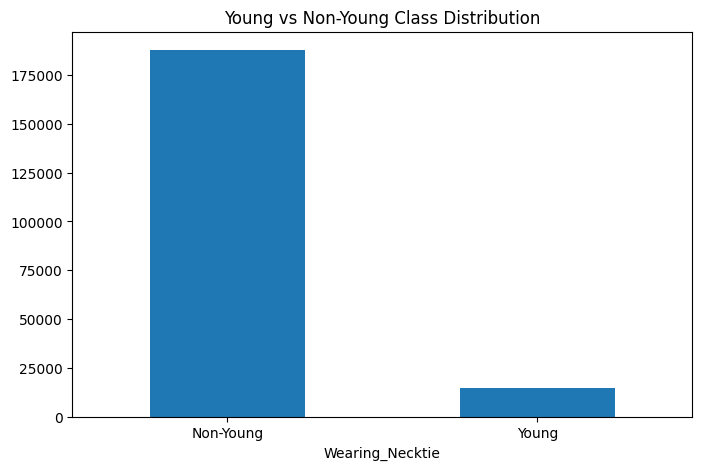

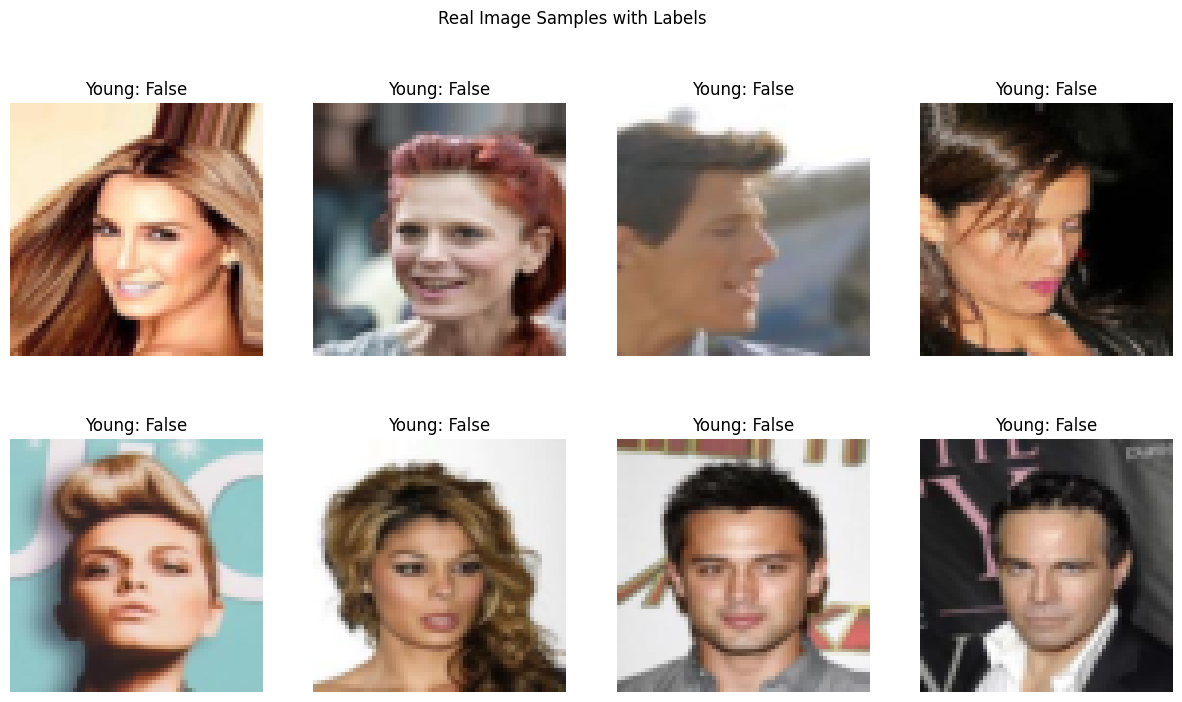

In [19]:
# Class Distribution
plt.figure(figsize=(8,5))
pd.Series(full_dataset.attributes.iloc[:, 39]).value_counts().plot(kind='bar')
plt.title('Young vs Non-Young Class Distribution')
plt.xticks([0, 1], ['Non-Young', 'Young'], rotation=0)
plt.show()

# Image Samples with Attributes
def show_real_samples(num_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    for idx, ax in enumerate(axes.flat):
        img, label = full_dataset[idx]
        ax.imshow(img.permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize
        ax.set_title(f"Young: {bool(label)}")
        ax.axis('off')
    plt.suptitle('Real Image Samples with Labels', y=0.98)
    plt.show()

show_real_samples()

In [34]:
# Add these at the top
from torch.utils.data import ConcatDataset, Subset, TensorDataset
from sklearn.manifold import TSNE
import seaborn as sns

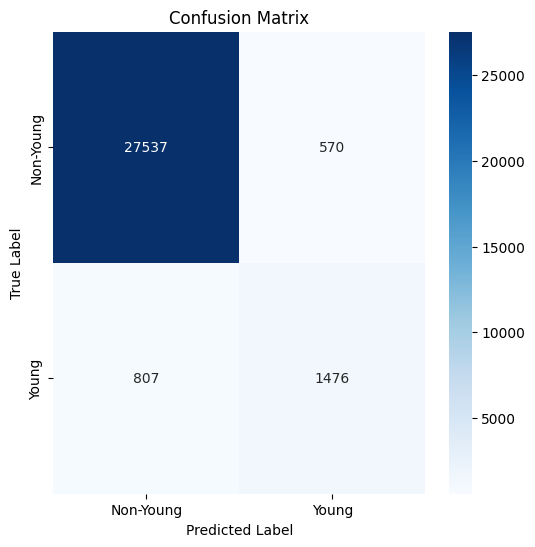

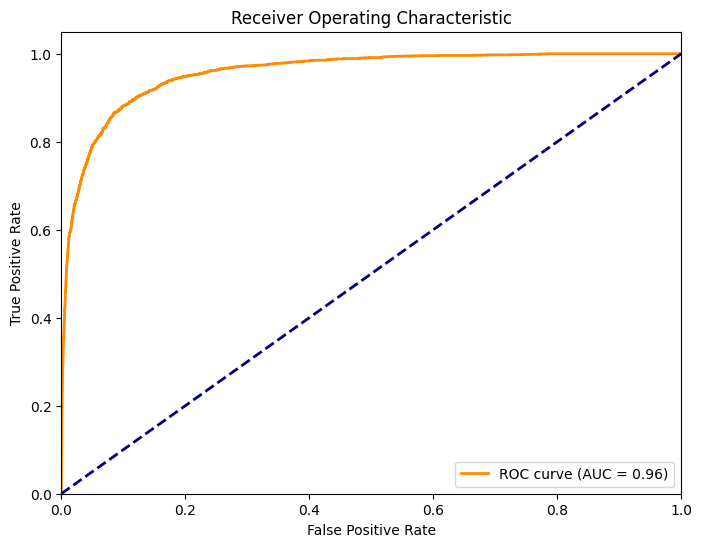

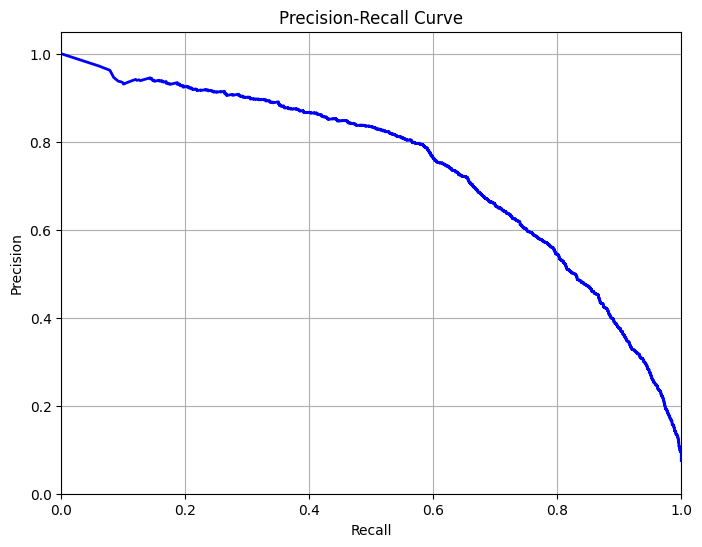

In [35]:
# First get predictions and probabilities
classifier.eval()
test_probs = []
test_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = classifier(images).squeeze()
        test_probs.extend(outputs.cpu().numpy())
        test_labels.extend(labels.numpy())

# Convert to numpy arrays
test_probs = np.array(test_probs)
test_labels = np.array(test_labels)
test_preds = (test_probs >= 0.5).astype(int)

# Now call the visualization functions
plot_confusion_matrix(test_labels, test_preds)
plot_roc_curve(test_labels, test_probs)
plot_pr_curve(test_labels, test_probs)

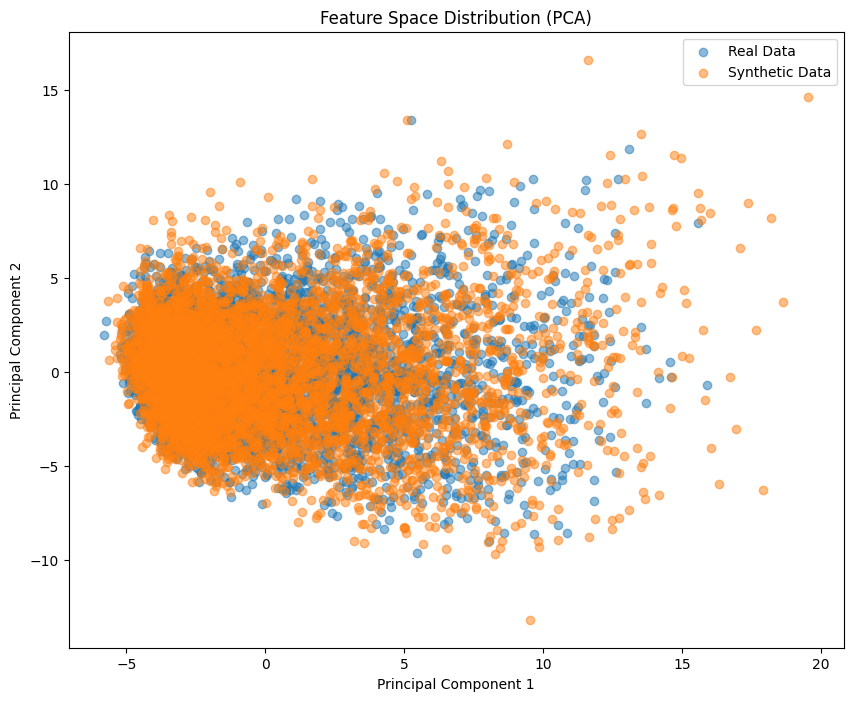

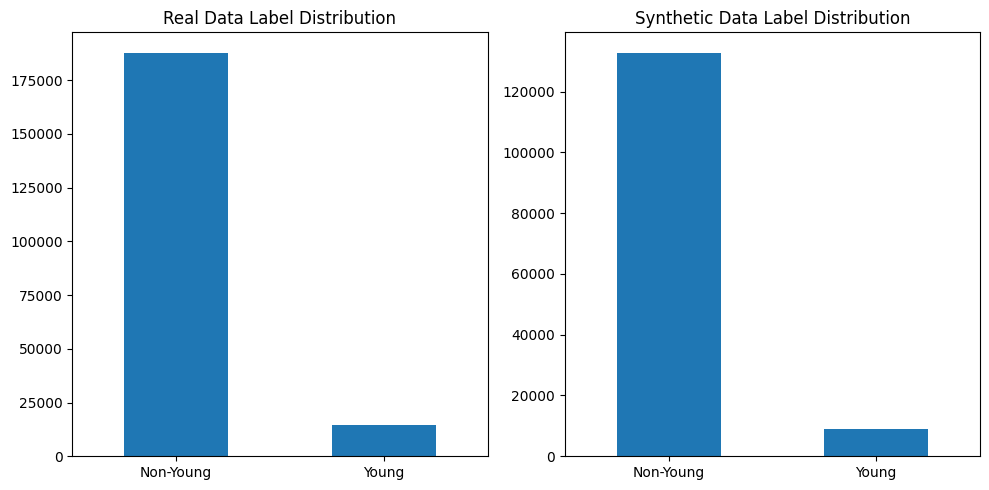

In [36]:
# Generate synthetic data
generator.eval()
num_synthetic = len(train_dataset)
synthetic_images = []
with torch.no_grad():
    for _ in range(0, num_synthetic, batch_size):
        z = torch.randn(batch_size, 100, 1, 1, device=device)
        synthetic_images.append(generator(z).cpu())
synthetic_images = torch.cat(synthetic_images)[:num_synthetic]

# Annotate synthetic data
synthetic_labels = []
with torch.no_grad():
    for batch in torch.split(synthetic_images, batch_size):
        outputs = classifier(batch.to(device)).squeeze()
        synthetic_labels.extend((outputs >= 0.5).float().cpu().numpy())
synthetic_labels = np.array(synthetic_labels)

# Get real data features
real_features = []
real_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
with torch.no_grad():
    for images, _ in real_loader:
        features = classifier.main[:4](images.to(device))  # Get features from first 4 layers
        real_features.extend(features.view(features.size(0), -1).cpu().numpy())
real_features = np.array(real_features)

# Get synthetic features
synthetic_features = []
with torch.no_grad():
    for batch in torch.split(synthetic_images, batch_size):
        features = classifier.main[:4](batch.to(device))
        synthetic_features.extend(features.view(features.size(0), -1).cpu().numpy())
synthetic_features = np.array(synthetic_features)

# Call visualization functions
plot_feature_distribution(real_features[:5000], synthetic_features[:5000])  # Use subset for speed
plot_label_distribution(np.array(train_dataset.dataset.attributes.iloc[:, 39].values), synthetic_labels)

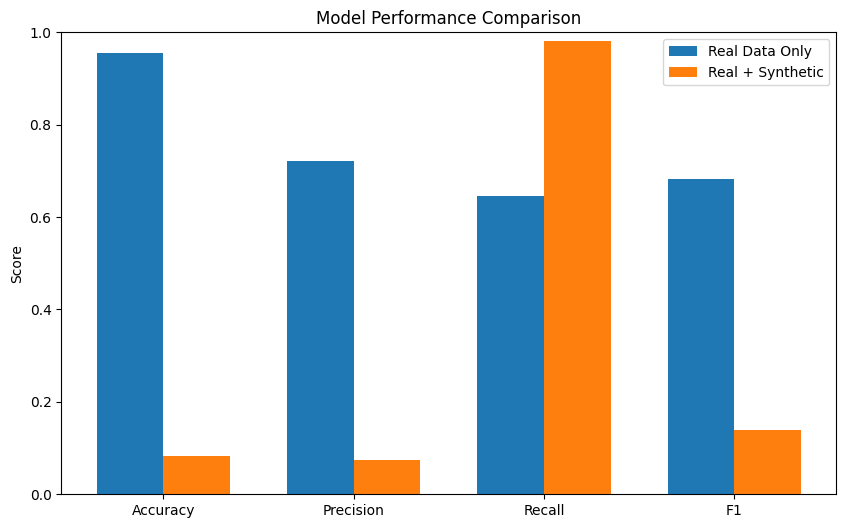

In [37]:
# First train and evaluate two models
# Model 1: Real data only (already trained)
real_metrics = [
    accuracy_score(test_labels, test_preds),
    precision_score(test_labels, test_preds),
    recall_score(test_labels, test_preds),
    f1_score(test_labels, test_preds)
]

# Model 2: Real + Synthetic (need to train)
# Create combined dataset
combined_dataset = ConcatDataset([
    Subset(train_dataset, indices=range(int(len(train_dataset)*0.3))),  # 30% real
    TensorDataset(synthetic_images, torch.tensor(synthetic_labels).float())  # 70% synthetic
])

# Train new classifier
combined_loader = DataLoader(combined_dataset, batch_size=64, shuffle=True)
combined_classifier = Classifier().to(device)
# ... training loop same as before ...

# Evaluate combined model
combined_test_true, combined_test_pred = evaluate_classifier(combined_classifier, test_loader)
synthetic_metrics = [
    accuracy_score(combined_test_true, combined_test_pred),
    precision_score(combined_test_true, combined_test_pred),
    recall_score(combined_test_true, combined_test_pred),
    f1_score(combined_test_true, combined_test_pred)
]

# Now call comparison
compare_models(real_metrics, synthetic_metrics)

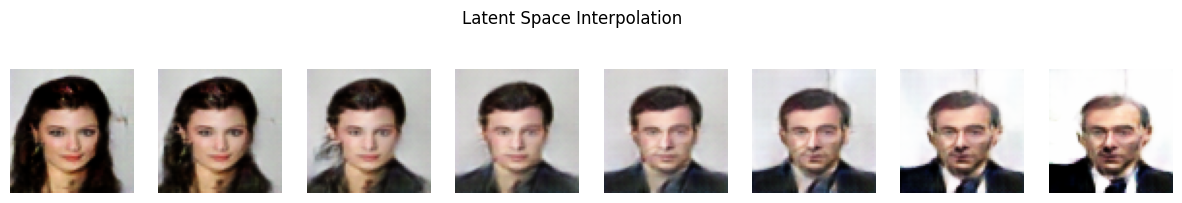

In [32]:
import numpy as np
# Latent Space Interpolation
def interpolate_latent_vectors(generator, z1, z2, steps=8):
    generator.eval()
    with torch.no_grad():
        interpolations = []
        for alpha in np.linspace(0, 1, steps):
            z = alpha * z1 + (1 - alpha) * z2
            interpolations.append(generator(z))
    
    plt.figure(figsize=(15, 3))
    for i, img in enumerate(interpolations):
        plt.subplot(1, steps, i+1)
        plt.imshow(img.squeeze().cpu().permute(1, 2, 0) * 0.5 + 0.5)
        plt.axis('off')
    plt.suptitle('Latent Space Interpolation', y=0.9)
    plt.show()

# Create sample latent vectors
z1 = torch.randn(1, 100, 1, 1, device=device)
z2 = torch.randn(1, 100, 1, 1, device=device)
interpolate_latent_vectors(generator, z1, z2)